In [9]:
!pwd

/home2/wangchenhao/Notebook/Meg/Super-Resolution


## 超分辨率训练和测试范例

这里提供一个超分辨率模型的训练和测试范例。

首先，我们假定您的训练数据和测试数据存在下面的位置：

In [10]:
TRAIN_RAW_DATA = "./dataset/train.tar"
TEST_RAW_DATA = "./dataset/test.tar"

### 处理训练数据

解开 `train.tar` 可以发现，训练数据都是以视频的格式提供的。4K 大小的视频文件以类似 `1.mp4` 的文件名提供，而压缩过的视频以类似 `1.mp4_down4x.mp4` 的文件名提供。因此，我们使用 PyAV 来处理视频数据，并从中提取一部分数据，存储为 npy 格式以供训练。首先，安装 PyAV：

In [ ]:
!pip3 install av --user

安装完成后，如果您使用 Jupyter，您需要在工具栏上重启 Python Kernel。

假定您要将训练数据存储在下面位置：

In [12]:
TRAIN_DATA_STORAGE = "./train_patches"

In [11]:
import numpy as np
import random
import os
import cv2
import tarfile
import io
import av
from tqdm import tqdm


则用下面的代码处理您的训练数据：

In [ ]:

# 统计视频帧数
def frame_count(container, video_stream=0):
    def count(generator):
        res = 0
        for _ in generator:
            res += 1
        return res

    frames = container.streams.video[video_stream].frames
    if frames != 0:
        return frames
    frame_series = container.decode(video=video_stream)
    frames = count(frame_series)
    container.seek(0)
    return frames

random.seed(100)
tar = tarfile.open(TRAIN_RAW_DATA)
os.makedirs(TRAIN_DATA_STORAGE, exist_ok=True)

name_info = {} # map
todo_list = []
while True:
    tinfo = tar.next()
    if tinfo is None:
        break
    if not tinfo.isfile():
        continue
    tname = tinfo.name
    name_info[tname] = tinfo
    if tname.endswith("_down4x.mp4"):
        todo_list.append(tname)

count = 0
for tname in tqdm(todo_list):
    tinfo = name_info[tname]
    srcinfo = name_info[tname.replace('_down4x.mp4', '')]

    f_down4x = tar.extractfile(tinfo)    # 下采样版本的视频
    f_origin = tar.extractfile(srcinfo)  # 原始视频

    container_down4x = av.open(f_down4x)
    container_origin = av.open(f_origin)

    frames_down4x = container_down4x.decode(video=0)
    frames_origin = container_origin.decode(video=0)

    fc_down4x = frame_count(container_down4x)
    fc_origin = frame_count(container_origin)
    extra = fc_down4x - fc_origin
    
    # 由于视频编码和 FFmpeg 实现的问题，压缩前后的帧数可能会不等，下采样版本的视频可能数量少几帧。
    # 这时，您需要注意跳过下采样版本视频缺少的帧数。
    if extra > 0:
        for _ in range(extra):
            next(frames_down4x)

    for k, (frame_down4x,
            frame_origin) in enumerate(zip(frames_down4x, frames_origin)):
        if random.random() < 0.1:
            img_origin = frame_origin.to_rgb().to_ndarray()
            if img_origin.shape[0] < 256 or img_origin.shape[1] < 256:
                continue
                
            img_down4x = frame_down4x.to_rgb().to_ndarray()
            img_down4x = cv2.resize(
                img_down4x, (img_origin.shape[1], img_origin.shape[0]))

            x0 = random.randrange(img_origin.shape[0] - 256 + 1)
            y0 = random.randrange(img_origin.shape[1] - 256 + 1)

            img_show = np.float32(
                np.stack((img_down4x[x0:x0 + 256, y0:y0 + 256].transpose((2, 0, 1)),
                          img_origin[x0:x0 + 256, y0:y0 + 256].transpose((2, 0, 1))))) / 256
            np.save(os.path.join(TRAIN_DATA_STORAGE, '%04d.npy' % count), img_show)
            count += 1

    container_down4x.close()
    container_origin.close()
    f_down4x.close()
    f_origin.close()

## 构建网络

作为示例，我们构建一个简单的网络。

In [19]:
import megengine as mge
import megengine.module as M
import megengine.functional as F
DEVICE = 'gpu2'

def addLeakyRelu(x):
    return M.Sequential(x, M.LeakyReLU(0.2))

def addPadding(x):
    shape = x.shape
    padding_shape = [(k + 1) // 2 * 2 for k in shape]
    res = mge.zeros(padding_shape, dtype=x.dtype)
    res = res.set_subtensor(x)[:shape[0], :shape[1], :shape[2], :shape[3]]
    res.to(DEVICE) # 选定GPU
    return res

class SimpleUNet(M.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = addLeakyRelu(M.Conv2d(3, 32, 4, padding=1, stride=2))
        self.conv1 = addLeakyRelu(M.Conv2d(32, 64, 4, padding=1, stride=2))
        self.conv2 = addLeakyRelu(M.Conv2d(64, 128, 4, padding=1, stride=2))
        self.conv3 = addLeakyRelu(M.Conv2d(128, 256, 4, padding=1, stride=2))
        self.conv4 = addLeakyRelu(M.Conv2d(256, 512, 4, padding=1, stride=2))
        self.conv5 = addLeakyRelu(M.Conv2d(512, 1024, 4, padding=1, stride=2))
        self.deconv5 = addLeakyRelu(M.ConvTranspose2d(1024, 512, 4, stride=2, padding=1))
        self.deconv4 = addLeakyRelu(M.ConvTranspose2d(1024, 256, 4, stride=2, padding=1))
        self.deconv3 = addLeakyRelu(M.ConvTranspose2d(512, 128, 4, stride=2, padding=1))
        self.deconv2 = addLeakyRelu(M.ConvTranspose2d(256, 64, 4, stride=2, padding=1))
        self.deconv1 = addLeakyRelu(M.ConvTranspose2d(128, 32, 4, stride=2, padding=1))
        self.deconv0 = addLeakyRelu(M.ConvTranspose2d(64, 3, 4, stride=2, padding=1))

    def forward(self, x):
        conv0 = addPadding(self.conv0(x))
        conv1 = addPadding(self.conv1(conv0))
        conv2 = addPadding(self.conv2(conv1))
        conv3 = addPadding(self.conv3(conv2))
        conv4 = addPadding(self.conv4(conv3))
        conv5 = self.conv5(conv4)

        conv5 = self.deconv5(conv5)[:, :, :conv4.shape[2], :conv4.shape[3]]  #  1/32   512
        conv4 = self.deconv4(F.concat([conv5, conv4], 1))[:, :, :conv3.shape[2], :conv3.shape[3]]  #  1/16   256
        conv3 = self.deconv3(F.concat([conv4, conv3], 1))[:, :, :conv2.shape[2], :conv2.shape[3]]  #  1/8   128
        conv2 = self.deconv2(F.concat([conv3, conv2], 1))[:, :, :conv1.shape[2], :conv1.shape[3]]  #  1/4   64
        conv1 = self.deconv1(F.concat([conv2, conv1], 1))[:, :, :conv0.shape[2], :conv0.shape[3]]  #  1/2   32
        conv0 = self.deconv0(F.concat([conv1, conv0], 1))[:, :, :x.shape[2], :x.shape[3]]  #  1/1   3

        return conv0

## 训练网络

接下来我们开始训练网络。在此之前，假定您想要把网络存储在下面位置：

In [20]:
MODEL_PATH = "model.mge.state"

In [21]:
# train_patches = sorted([os.path.join(TRAIN_DATA_STORAGE, f) for f in os.listdir(TRAIN_DATA_STORAGE)])

使用下面的代码训练您的网络：

In [22]:
import time
from functools import lru_cache
from megengine.optimizer import Adam

train_steps = 1000
batch_size = 8
input_h = 256
input_w = 256



net = SimpleUNet()
optimizer = Adam(net.parameters(), lr=1e-4)

random.seed(100)

@lru_cache(maxsize=None)
def load_image(path):
    return np.load(path, mmap_mode="r")

train_patches = sorted([os.path.join(TRAIN_DATA_STORAGE, f) for f in os.listdir(TRAIN_DATA_STORAGE)])

def load_batch():
    batch_train = []
    batch_gt = []
    for i in range(batch_size):
        path = random.choice(train_patches)
        img = load_image(path)
        batch_train.append(img[0])
        batch_gt.append(img[1])
    return np.array(batch_train), np.array(batch_gt)

@mge.jit.trace
def train_iter(batch_train, batch_gt):
    pred = net(batch_train)
    loss = F.abs(batch_gt - pred).mean()
    optimizer.backward(loss)
    return loss, pred

loss_acc = 0
loss_acc0 = 0

for it in range(train_steps + 1):
    for g in optimizer.param_groups:
        g['lr'] = 2e-4 * (train_steps - it) / train_steps

    begin = time.time()
    (batch_train, batch_gt) = load_batch()
    
    data_load_end = time.time()

    optimizer.zero_grad()
    loss, pred = train_iter(batch_train, batch_gt)
    optimizer.step()
    loss_acc = loss_acc * 0.99 + loss
    loss_acc0 = loss_acc0 * 0.99 + 1
    end = time.time()
    
    total_time = end - begin
    data_load_time = data_load_end - begin
    if it % 100 == 0:
        print(
            "{}: loss: {}, speed: {:.2f}it/sec, tot: {:.4f}s, data: {:.4f}s, data/tot: {:.4f}"
            .format(it, loss_acc / loss_acc0, 1 / total_time, total_time,
                    data_load_time, data_load_time / total_time))

# 存储模型
state = {
    'net': net.state_dict(),
    'opt': optimizer.state_dict(),
}
with open(MODEL_PATH, 'wb') as fout:
    mge.save(state, fout)
    

0: loss: Tensor([0.4993]), speed: 0.13it/sec, tot: 7.6974s, data: 0.0095s, data/tot: 0.0012
100: loss: Tensor([0.1454]), speed: 13.96it/sec, tot: 0.0717s, data: 0.0074s, data/tot: 0.1027
200: loss: Tensor([0.0723]), speed: 11.19it/sec, tot: 0.0894s, data: 0.0098s, data/tot: 0.1093
300: loss: Tensor([0.0479]), speed: 14.25it/sec, tot: 0.0702s, data: 0.0074s, data/tot: 0.1050
400: loss: Tensor([0.0378]), speed: 15.48it/sec, tot: 0.0646s, data: 0.0053s, data/tot: 0.0826
500: loss: Tensor([0.0331]), speed: 16.07it/sec, tot: 0.0622s, data: 0.0045s, data/tot: 0.0718
600: loss: Tensor([0.0312]), speed: 15.71it/sec, tot: 0.0636s, data: 0.0041s, data/tot: 0.0652
700: loss: Tensor([0.0291]), speed: 14.43it/sec, tot: 0.0693s, data: 0.0034s, data/tot: 0.0489
800: loss: Tensor([0.0287]), speed: 15.60it/sec, tot: 0.0641s, data: 0.0042s, data/tot: 0.0653
900: loss: Tensor([0.0281]), speed: 15.90it/sec, tot: 0.0629s, data: 0.0035s, data/tot: 0.0555
1000: loss: Tensor([0.0276]), speed: 15.80it/sec, tot

## 加载网络并推理

训练完成后，就可以加载网络并进行推理：

(270, 360, 3)
(1, 3, 1080, 1440)
(2, 3, 1080, 1440)
(2545831, 1)


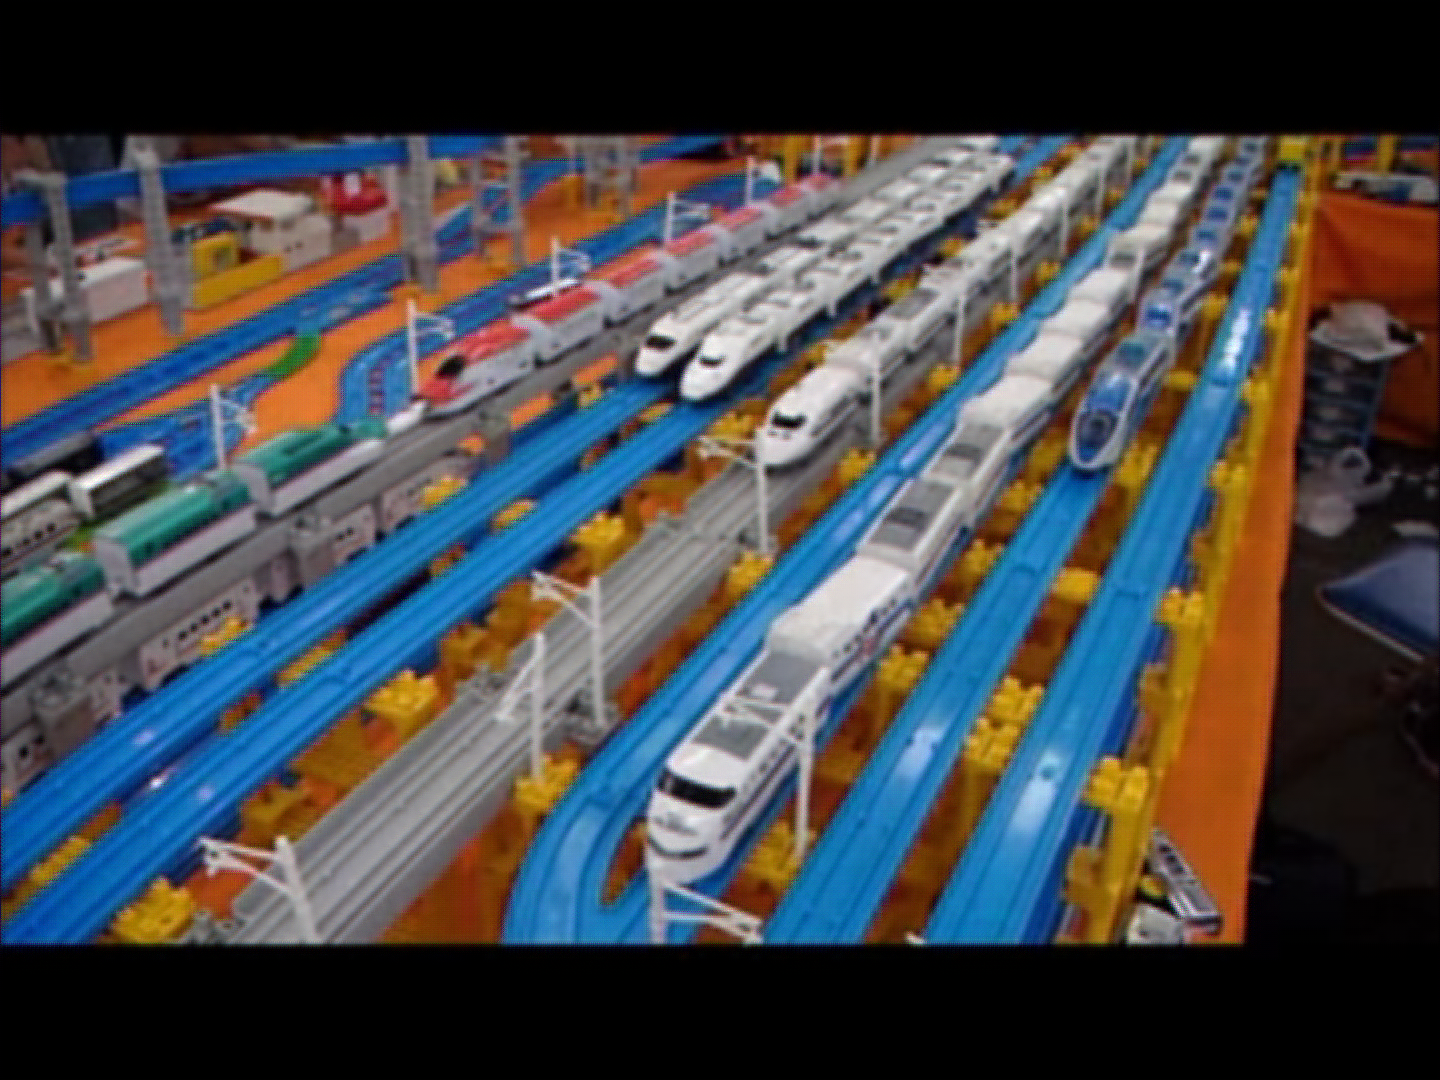

In [31]:
from IPython.display import Image, display

net = SimpleUNet()

with open(MODEL_PATH, 'rb') as f:
    net.load_state_dict(mge.load(f)['net'])
    
@mge.jit.trace
def inference(inp):
    return net(inp)

with tarfile.open(TEST_RAW_DATA, mode='r') as tar:
    tinfo = tar.getmember("test/90/0045.png")
    content = tar.extractfile(tinfo).read()
    img = cv2.imdecode(np.frombuffer(content, dtype='uint8'), 1)
    print(img.shape)
    img = cv2.resize(img, (0, 0), fx=4, fy=4) # 输出为原来的4倍，默认双线性插值
    img = (np.float32(img) / 256).transpose((2, 0, 1))[None, :, :, :]
    print(img.shape)
    img_out = inference(img)
    print(img_out.shape)
    img_out = (img_out.numpy() * 256).clip(0, 255)[0].transpose((1, 2, 0)).copy()
    content_out = cv2.imencode('.png', img_out)[1]
    cv2.imwrite("test_up_0045.png", content_out) #保存图片
    
    #print(content_out.shape)
    display(Image(data=content_out, width=400))